In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator

## The Proposed Problem

Use Girvan-Newman method to
1. Evaluate and promote the criticality of bridges in a given transportation network that is overshadowed by network redundancy
2. Reduce the number of links in network or the size of the network to be closed to the number of bridges.

There are 4 main steps:
1. STEP 1: Define Link Weight
2. STEP 2: Clustering Girvan Newman
3. STEP 3: Adjust Bridge Dominance
4. STEP 4: Big Node and Super Link


#### NOTE:
In this work, the constructions of new big node and deletion of link (Step 3 and Step 4)  are manually conceptualized. Hence, there is no code or algorithm to it. The improvement is needed to make a direct algorithm to evaluate and reconstruct new network for Step 3 and Step 4.

### ALGORITHM TRIAL ON LOW REDUNDANCY
#### 1. Creating the graph

C:\Users\denis\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


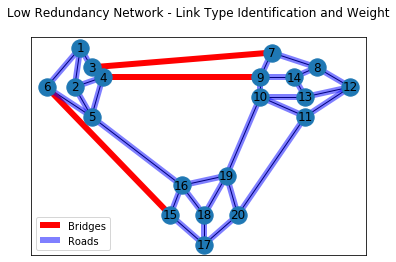

In [2]:
#Assumption: In this clustering algorithm, the graph is considered as undirected graph
edges = pd.read_csv('LowNetworkRedundancy_Undirected_edge.csv')
G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4'], create_using=nx.Graph())
G.add_node(1, loc=(5,22))
G.add_node(2, loc=(4.5,18))
G.add_node(3, loc=(6,20))
G.add_node(4, loc=(7,19))
G.add_node(5, loc=(6,15))
G.add_node(6, loc=(2,18))
G.add_node(7, loc=(22,21.5))
G.add_node(8, loc=(26, 20))
G.add_node(9, loc=(21,19))
G.add_node(10, loc=(21, 17))
G.add_node(11, loc=(25,15))
G.add_node(12, loc=(29, 18))
G.add_node(13, loc=(25, 17))
G.add_node(14, loc=(24, 19))
G.add_node(15, loc=(13, 5))
G.add_node(16, loc=(14, 8))
G.add_node(17, loc=(16,2))
G.add_node(18, loc=(16,5))
G.add_node(19, loc=(18, 9))
G.add_node(20, loc=(19, 5))

# Attributes
loc = nx.get_node_attributes(G, 'loc')
delay = nx.get_edge_attributes(G, 'delay')
cap = nx.get_edge_attributes(G, 'cap')
cost = nx.get_edge_attributes(G, 'cost')
w1 = nx.get_edge_attributes(G, 'w1')
w2 = nx.get_edge_attributes(G, 'w2')
w3 = nx.get_edge_attributes(G, 'w3')
w4 = nx.get_edge_attributes(G, 'w4')
types = nx.get_edge_attributes(G,'bridge')
edgelist_type=list(G.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 0]

# Plotting
nx.draw_networkx(G, loc)
nx.draw_networkx_edges(G, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
plt.title('Low Redundancy Network - Link Type Identification and Weight\n')
plt.legend(loc='best')
plt.savefig('LowNetwork-label.png', dpi=500)
plt.show()

In [3]:
nx.average_node_connectivity(G, flow_func=None)

3.0789473684210527

In [4]:
nx.eccentricity(G, v=None, sp=None)

{1: 5,
 2: 5,
 3: 5,
 6: 5,
 4: 4,
 5: 5,
 7: 5,
 8: 5,
 9: 4,
 12: 5,
 14: 5,
 10: 4,
 11: 5,
 13: 5,
 15: 5,
 16: 5,
 17: 5,
 18: 5,
 19: 4,
 20: 5}

#### STEP 1 - Edges Betweenness of Original Network

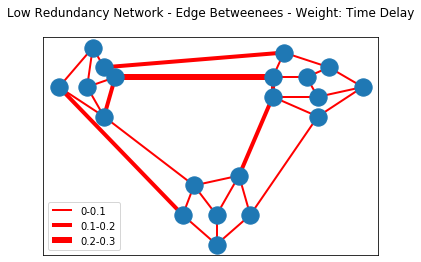

In [5]:
ebet=nx.edge_betweenness_centrality(G, normalized=True, weight='delay')

# Update Network Data
edgelist=list(G.edges())
i=0
for (u, v, d) in G.edges(data=True):
    d['ebet'] = ebet.get(edgelist[i])
    i+=1
    
# Attribute
edgelist_ebet=list(G.edges(data='ebet'))
ebetlist = [d for u,v,d in edgelist_ebet]
list_1 = [(u, v) for (u, v, d) in edgelist_ebet if d < 0.1]
list_2 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.1 and d < 0.2]
list_3 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.2 and d < 0.3]
list_4 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.3 ]

# Plotting
nx.draw_networkx_nodes(G, loc)
nx.draw_networkx_edges(G, loc, edgelist=list_1, width=2, edge_color='r', label='0-0.1')
nx.draw_networkx_edges(G, loc, edgelist=list_2, width=4, edge_color='r', label='0.1-0.2')
nx.draw_networkx_edges(G, loc, edgelist=list_3, width=6, edge_color='r', label='0.2-0.3')
nx.draw_networkx_edges(G, loc, edgelist=list_4, width=8, edge_color='r', label='>=0.3')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
plt.title('Low Redundancy Network - Edge Betweenees - Weight: Time Delay\n')
plt.legend(loc='best')
plt.savefig('LowNetwork_ebet.png', dpi=500)
plt.show()

#### STEP 2 - Modified Girvan-Newman Algorithm

In [6]:
#ALMOST>>>>
G_clustered = G
edgelist_deleted=[] #detect every important link
x = sorted(nx.connected_components(G), key=len, reverse=True)
k = 0
remaining_bridge = set(bridge) - set(edgelist_deleted)

# In here, we want to make sure that bridge always important. Meaning that bridge always become the link within 2 clusters or more.
# To do that, we need to keep breaking out bridge and enforce bridge to be out of the cluster.
# This piece of code is to detect and investigate in each current generated clusters if there is a bridge inside our cluster. 
# If yes, do the girvan newman for that cluster and pullout the bridge (if it is possible) by breaking up our current investigated cluster into new buset of clusters

#For every k component in set x do this:
for k in range(100):
    if k <= 100:
        G1 = G.subgraph(x[0]) # 1. Create subgraph of component k in set x
        SG_edgelist=list(G1.edges(data=True))
        SG_edgelistonly=list(G1.edges())
        SG_nodelist=list(G1.nodes(data=True))
        G1 = nx.Graph()
        G1.add_nodes_from(SG_nodelist)
        G1.add_edges_from(SG_edgelist)
        if any((u,v) in bridge for (u,v) in SG_edgelistonly): 
            # 2. If at least one remaining bridge in this component, do this:     
            while nx.is_connected(G1): #Girvan-Newman
                ebet=nx.edge_betweenness_centrality(G1,normalized=True, weight='delay')
                edgelist=list(G.edges())
                i=0
                for (u, v, d) in G.edges(data=True):
                    d['ebet'] = ebet.get(edgelist[i])
                    i+=1
                edgelist_ebet=list(G.edges(data='ebet'))
                maxEbet=max(ebet.values())
                maxEdge=max(ebet, key=ebet.get)
                #identical_check=[(u, v) for (u, v, d) in edgelist_ebet if d == maxEbet]
                #for u,v in identical_check:
                    #if types[(u,v)]==1:
                        #maxEdge = (u,v)
                        #continue
                edgelist_deleted.append(maxEdge)
                if maxEdge in G_clustered.edges():
                    G_clustered.remove_edge(maxEdge[0],maxEdge[1])
                else:
                    G_clustered.remove_edge(maxEdge[1],maxEdge[0])
                if maxEdge in G1.edges():
                    G1.remove_edge(maxEdge[0],maxEdge[1])
                else:
                    G1.remove_edge(maxEdge[1],maxEdge[0])
            remaining_bridge = set(bridge) - set(edgelist_deleted)
            x=[c for c in sorted(nx.connected_components(G_clustered), key=len, reverse=True)]
            k = 0  # retrun ke looping k component
        else:
            k +=1  # retrun ke looping k component
    else:
        break
    

#print(edgelist_ebet)
#print(edgelist_type)
#print(maxEbet)
#print(identical_check)
#print(maxEdge)
#print(edgelist_deleted)
#print(k)

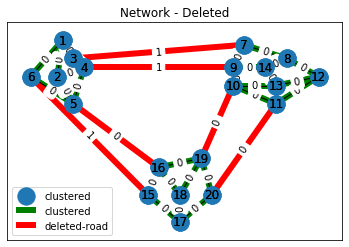

In [7]:
nx.draw_networkx(G_clustered, loc, width=6, edge_color='green', label='clustered')
nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=6, edge_color='r', label='deleted-road')
nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
nx.draw_networkx(G_clustered, loc)
plt.title('Network - Deleted')
plt.legend(loc='best')
plt.show()

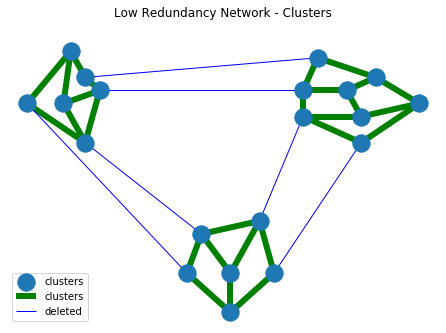

In [10]:
edgelist_type=list(G_clustered.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G_clustered.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G_clustered.edges(data=True) if d['bridge'] == 0]


nx.draw(G_clustered, loc, width=6, edge_color='green', label='clusters')
nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=1, edge_color='b', label='deleted')
nx.draw_networkx_edges(G_clustered, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
#nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=6, edge_color='r', label='deleted-road')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
plt.title('Low Redundancy Network - Clusters\n')
plt.legend(loc='best')
plt.savefig('LowNetwork-a.png', dpi=500)
plt.show()

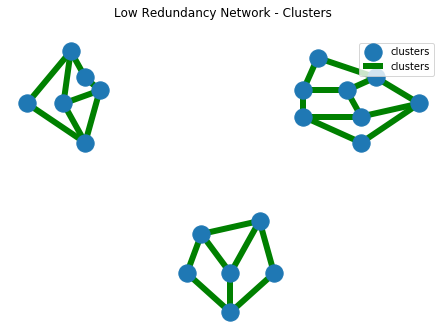

In [11]:
nx.draw(G_clustered, loc, width=6, edge_color='green', label='clusters')
#nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=1, edge_color='b', label='deleted')
nx.draw_networkx_edges(G_clustered, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
#nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=6, edge_color='r', label='deleted-road')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
plt.title('Low Redundancy Network - Clusters\n')
plt.legend(loc='best')
plt.savefig('LowNetwork-b.png', dpi=500)
plt.show()

#### STEP 3 - Adjust Bridge Dominance for each cluster pair

##### NOTE:
In this work, the constructions of new big node and deletion of link (Step 3 and Step 4)  are manually conceptualized. Hence, there is no code or algorithm to it. The improvement is needed to make a direct algorithm to evaluate and reconstruct new network for Step 3 and Step 4.


##### PAIR C1-C2

In [12]:
# Bridge Criticality Evaluation - BB
edges = pd.read_csv('LowNetworkRedundancy_Undirected_edge.csv')
G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4'], create_using=nx.Graph())
G.add_node(1, loc=(5,22))
G.add_node(2, loc=(4.5,18))
G.add_node(3, loc=(6,20))
G.add_node(4, loc=(7,19))
G.add_node(5, loc=(6,15))
G.add_node(6, loc=(2,18))
G.add_node(7, loc=(22,21.5))
G.add_node(8, loc=(26, 20))
G.add_node(9, loc=(21,19))
G.add_node(10, loc=(21, 17))
G.add_node(11, loc=(25,15))
G.add_node(12, loc=(29, 18))
G.add_node(13, loc=(25, 17))
G.add_node(14, loc=(24, 19))
G.add_node(15, loc=(13, 5))
G.add_node(16, loc=(14, 8))
G.add_node(17, loc=(16,2))
G.add_node(18, loc=(16,5))
G.add_node(19, loc=(18, 9))
G.add_node(20, loc=(19, 5))

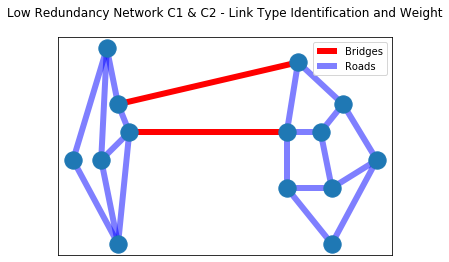

In [13]:
nodelist_BB = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
G1 = G.subgraph(nodelist_BB) # 1. Create subgraph of component k in set x
SG_edgelist=list(G1.edges(data=True))
SG_edgelistonly=list(G1.edges())
SG_nodelist=list(G1.nodes(data=True))
G1 = nx.Graph()
G1.add_nodes_from(SG_nodelist)
G1.add_edges_from(SG_edgelist)

# Attributes
loc = nx.get_node_attributes(G1, 'loc')
delay = nx.get_edge_attributes(G1, 'delay')
cap = nx.get_edge_attributes(G1, 'cap')
cost = nx.get_edge_attributes(G1, 'cost')
w1 = nx.get_edge_attributes(G1, 'w1')
w2 = nx.get_edge_attributes(G1, 'w2')
w3 = nx.get_edge_attributes(G1, 'w3')
w4 = nx.get_edge_attributes(G1, 'w4')
types = nx.get_edge_attributes(G1,'bridge')
edgelist_type=list(G1.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 0]

# Plotting
nx.draw_networkx_nodes(G1, loc)
nx.draw_networkx_edges(G1, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G1, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
plt.title('Low Redundancy Network C1 & C2 - Link Type Identification and Weight\n')
plt.legend(loc='best')
plt.savefig('LowNetwork - BB.png', dpi=500)
plt.show()

##### PAIR C1-C3

In [14]:
# Bridge Criticality Evaluation - BR
edges = pd.read_csv('LowNetworkRedundancy_Undirected_edge.csv')
G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4'], create_using=nx.Graph())
G.add_node(1, loc=(5,22))
G.add_node(2, loc=(4.5,18))
G.add_node(3, loc=(6,20))
G.add_node(4, loc=(7,19))
G.add_node(5, loc=(6,15))
G.add_node(6, loc=(2,18))
G.add_node(7, loc=(22,21.5))
G.add_node(8, loc=(26, 20))
G.add_node(9, loc=(21,19))
G.add_node(10, loc=(21, 17))
G.add_node(11, loc=(25,15))
G.add_node(12, loc=(29, 18))
G.add_node(13, loc=(25, 17))
G.add_node(14, loc=(24, 19))
G.add_node(15, loc=(13, 5))
G.add_node(16, loc=(14, 8))
G.add_node(17, loc=(16,2))
G.add_node(18, loc=(16,5))
G.add_node(19, loc=(18, 9))
G.add_node(20, loc=(19, 5))

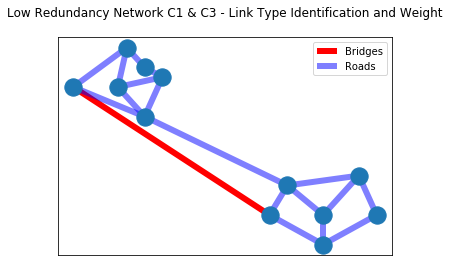

In [15]:
nodelist_BR = [1,2,3,4,5,6,15,16,17,18,19,20]
G1 = G.subgraph(nodelist_BR) # 1. Create subgraph of component k in set x
SG_edgelist=list(G1.edges(data=True))
SG_edgelistonly=list(G1.edges())
SG_nodelist=list(G1.nodes(data=True))
G1 = nx.Graph()
G1.add_nodes_from(SG_nodelist)
G1.add_edges_from(SG_edgelist)

# Attributes
loc = nx.get_node_attributes(G1, 'loc')
delay = nx.get_edge_attributes(G1, 'delay')
cap = nx.get_edge_attributes(G1, 'cap')
cost = nx.get_edge_attributes(G1, 'cost')
w1 = nx.get_edge_attributes(G1, 'w1')
w2 = nx.get_edge_attributes(G1, 'w2')
w3 = nx.get_edge_attributes(G1, 'w3')
w4 = nx.get_edge_attributes(G1, 'w4')
types = nx.get_edge_attributes(G1,'bridge')
edgelist_type=list(G1.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 0]

# Plotting
nx.draw_networkx_nodes(G1, loc)
nx.draw_networkx_edges(G1, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G1, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
plt.title('Low Redundancy Network C1 & C3 - Link Type Identification and Weight\n')
plt.legend(loc='best')
plt.savefig('LowNetwork - BR.png', dpi=500)
plt.show()

##### PAIR C2-C3

In [16]:
# Bridge Criticality Evaluation - RR
edges = pd.read_csv('LowNetworkRedundancy_Undirected_edge.csv')
G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4'], create_using=nx.Graph())
G.add_node(1, loc=(5,22))
G.add_node(2, loc=(4.5,18))
G.add_node(3, loc=(6,20))
G.add_node(4, loc=(7,19))
G.add_node(5, loc=(6,15))
G.add_node(6, loc=(2,18))
G.add_node(7, loc=(22,21.5))
G.add_node(8, loc=(26, 20))
G.add_node(9, loc=(21,19))
G.add_node(10, loc=(21, 17))
G.add_node(11, loc=(25,15))
G.add_node(12, loc=(29, 18))
G.add_node(13, loc=(25, 17))
G.add_node(14, loc=(24, 19))
G.add_node(15, loc=(13, 5))
G.add_node(16, loc=(14, 8))
G.add_node(17, loc=(16,2))
G.add_node(18, loc=(16,5))
G.add_node(19, loc=(18, 9))
G.add_node(20, loc=(19, 5))

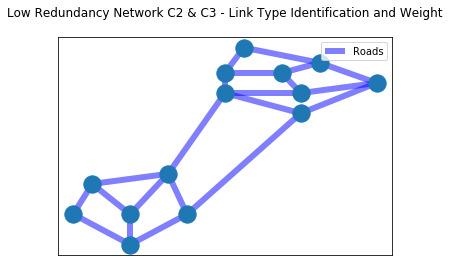

In [17]:
nodelist_RR = [7,8,9,10,11,12,13,14,15,16,17,18,19,20]
G1 = G.subgraph(nodelist_RR) # 1. Create subgraph of component k in set x
SG_edgelist=list(G1.edges(data=True))
SG_edgelistonly=list(G1.edges())
SG_nodelist=list(G1.nodes(data=True))
G1 = nx.Graph()
G1.add_nodes_from(SG_nodelist)
G1.add_edges_from(SG_edgelist)

# Attributes
loc = nx.get_node_attributes(G1, 'loc')
delay = nx.get_edge_attributes(G1, 'delay')
cap = nx.get_edge_attributes(G1, 'cap')
cost = nx.get_edge_attributes(G1, 'cost')
w1 = nx.get_edge_attributes(G1, 'w1')
w2 = nx.get_edge_attributes(G1, 'w2')
w3 = nx.get_edge_attributes(G1, 'w3')
w4 = nx.get_edge_attributes(G1, 'w4')
types = nx.get_edge_attributes(G1,'bridge')
edgelist_type=list(G1.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G1.edges(data=True) if d['bridge'] == 0]

# Plotting
nx.draw_networkx_nodes(G1, loc)
nx.draw_networkx_edges(G1, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G1, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
plt.title('Low Redundancy Network C2 & C3 - Link Type Identification and Weight\n')
plt.legend(loc='best')
plt.savefig('LowNetwork - RR.png', dpi=500)
plt.show()

#### STEP 4 - Big Node and Super Link with each clusters and each cluster pairs

##### NOTE:
In this work, the constructions of new big node and deletion of link (Step 3 and Step 4)  are manually conceptualized. Hence, there is no code or algorithm to it. The improvement is needed to make a direct algorithm to evaluate and reconstruct new network for Step 3 and Step 4.

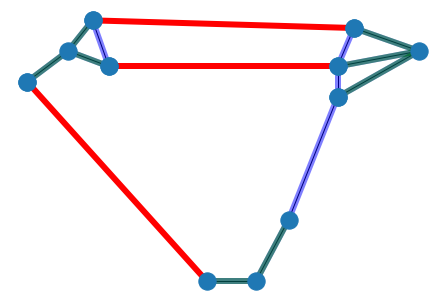

In [18]:
# Bridge Criticality Evaluation - RR
edges = pd.read_csv('LowNetworkRedundancyR_Undirected_edge.csv')
G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4', 'sl'], create_using=nx.Graph())
G.add_node('A', loc=(4.5,20))
G.add_node('B', loc=(26,20))
G.add_node(3, loc=(6,22))
G.add_node(4, loc=(7,19))
G.add_node('C', loc=(16,5))
G.add_node(6, loc=(2,18))
G.add_node(7, loc=(22,21.5))
G.add_node(9, loc=(21,19))
G.add_node(10, loc=(21, 17))
G.add_node(15, loc=(13, 5))
G.add_node(19, loc=(18, 9))
G.add_node('3', loc=(6,22))
G.add_node('4', loc=(7,19))
G.add_node('6', loc=(2,18))
G.add_node('7', loc=(22,21.5))
G.add_node('10', loc=(21, 17))
G.add_node('9', loc=(21,19))

# Attributes
loc = nx.get_node_attributes(G, 'loc')
delay = nx.get_edge_attributes(G, 'delay')
cap = nx.get_edge_attributes(G, 'cap')
cost = nx.get_edge_attributes(G, 'cost')
w1 = nx.get_edge_attributes(G, 'w1')
w2 = nx.get_edge_attributes(G, 'w2')
w3 = nx.get_edge_attributes(G, 'w3')
w4 = nx.get_edge_attributes(G, 'w4')
types = nx.get_edge_attributes(G,'bridge')
edgelist_type=list(G.edges(data='bridge'))
sl = nx.get_edge_attributes(G,'sl')
edgelist_sl=list(G.edges(data='sl'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 0]
link_s = [(u, v) for (u, v, d) in G.edges(data=True) if d['sl'] == 1]

# Plotting
nx.draw(G, loc)
nx.draw_networkx_edges(G, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
nx.draw_networkx_edges(G, loc, edgelist=link_s, width=6, alpha=0.5, edge_color='g', label='Super Links')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
#plt.title('Final Reduced Network - Link Type Identification and Weight\n')
#plt.legend(loc='best')
plt.savefig('LowNetwork-Reduced.png', dpi=500)

In this work, the constructions of new big node and deletion of link (Step 3 and Step 4)  are manually conceptualized. Improvement is needed to make a direct algorithm to evaluate and reconstruct new network for Step 3 and Step 4